In [1]:
!python --version

Python 3.12.7


# Predict Bike Sharing Demand with AutoGluon

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from autogluon.tabular import TabularPredictor
from autogluon.common import space

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10, 8)

In [3]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train[train.columns[1:]].describe().T # except datetime column

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [6]:
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
submission = pd.read_csv("data/sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [8]:
print(train.shape, test.shape, submission.shape)

(10886, 12) (6493, 9) (6493, 2)


## Train a Model Using AutoGluon’s Tabular Prediction

**Requirements:**

- We are predicting `count`, so it is the label we are setting.
- Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
- Use the `root_mean_squared_error` as the metric to use for evaluation.
- Set a time limit of 10 minutes (600 seconds).
- Use the preset `best_quality` to focus on creating the best model.

In [ ]:
predictor = TabularPredictor(
    label="count",
    problem_type="regression",
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]},
    verbosity=0,
).fit(
    train,
    time_limit=600,
    presets="best_quality",
    num_gpus=1
)

In [9]:
predictor = TabularPredictor.load("AutogluonModels/ag-20250316_142502/")

In [10]:
predictor.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-51.617844,root_mean_squared_error,13.632703,312.952076,0.002001,0.111992,3,True,16
1,NeuralNetFastAI_BAG_L2,-53.396362,root_mean_squared_error,12.548690,291.017452,0.316632,29.477273,2,True,15
2,RandomForestMSE_BAG_L2,-53.447203,root_mean_squared_error,12.781518,279.205227,0.549460,17.665047,2,True,12
3,ExtraTreesMSE_BAG_L2,-53.719107,root_mean_squared_error,12.764610,265.697764,0.532552,4.157585,2,True,14
4,LightGBM_BAG_L2,-54.779800,root_mean_squared_error,12.511848,268.460753,0.279789,6.920574,2,True,11
5,CatBoost_BAG_L2,-55.645959,root_mean_squared_error,12.279170,306.508216,0.047112,44.968037,2,True,13
6,LightGBMXT_BAG_L2,-60.674882,root_mean_squared_error,18.071033,280.731702,5.838974,19.191523,2,True,10
7,KNeighborsDist_BAG_L1,-84.146423,root_mean_squared_error,0.036369,0.040516,0.036369,0.040516,1,True,2
8,WeightedEnsemble_L2,-84.146423,root_mean_squared_error,0.038544,0.143124,0.002176,0.102607,2,True,9
9,KNeighborsUnif_BAG_L1,-101.588176,root_mean_squared_error,0.035652,0.057379,0.035652,0.057379,1,True,1


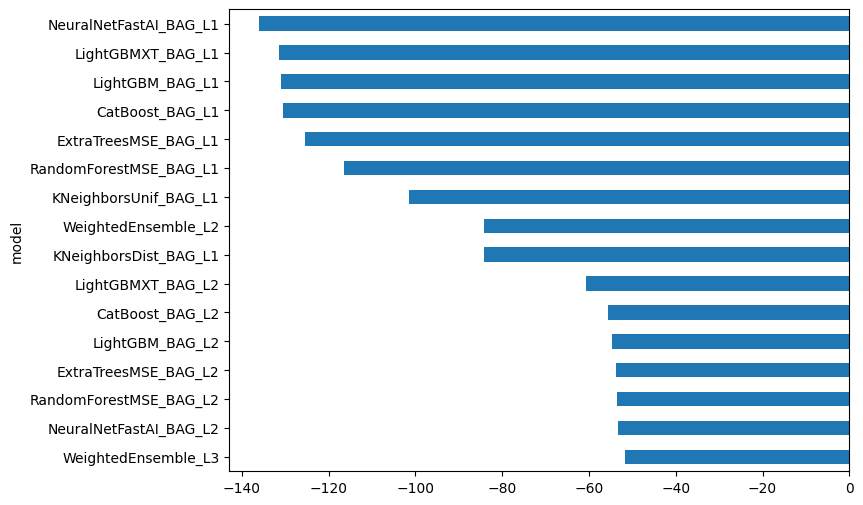

In [11]:
predictor.leaderboard(silent=True).plot(figsize=(8, 6), kind="barh", x="model", y="score_val", legend=False);

In [12]:
predictions = predictor.predict(test)
predictions.head()

0    24.646412
1    44.076263
2    48.176926
3    49.377071
4    51.902748
Name: count, dtype: float32

In [13]:
# Kaggle will reject the submission if we don't set everything to be > 0.
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      101.357719
std        88.044952
min         1.919887
25%        23.545647
50%        69.661156
75%       168.681610
max       353.281555
Name: count, dtype: float64

In [14]:
predictions[predictions < 0].sum()

0.0

In [15]:
# Set predictions to submission dataframe, save, and submit
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

In [16]:
# View submission via the command line or in the web browser under the competition's page - `My Submissions`
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                        description                        status                     publicScore  privateScore  
---------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
submission_new_hpo.csv       2025-03-16 18:46:47.077000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.47256      0.47256       
submission_new_features.csv  2025-03-16 16:27:53.403000  new features                       SubmissionStatus.COMPLETE  0.46987      0.46987       
submission.csv               2025-03-16 15:00:09.723000  first raw submission               SubmissionStatus.COMPLETE  1.75122      1.75122       


<font color="blue"> 

Initial score - **1.75122**

</font>

## Exploratory Data Analysis and Creating Additional Features

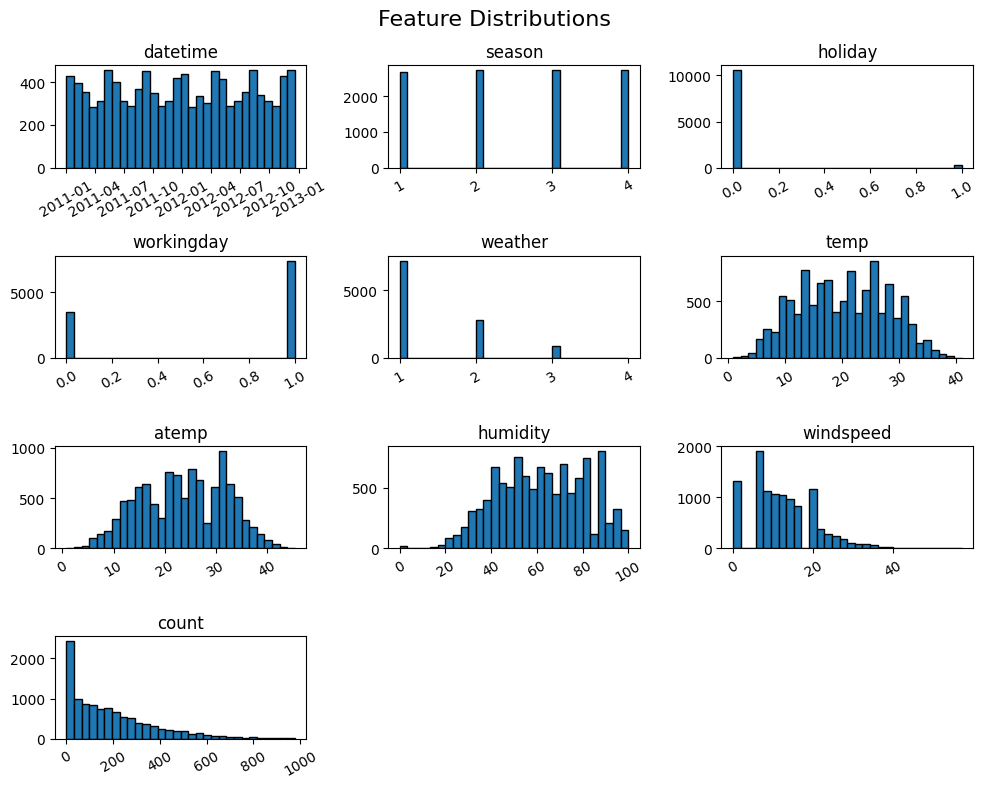

In [17]:
columns_to_plot = train.drop(columns=["casual", "registered"])
columns_to_plot.hist(figsize=(10, 8), bins=30, edgecolor="black", grid=False)
plt.suptitle("Feature Distributions", fontsize=16)

# Rotate x-axis tick labels
for ax in plt.gcf().axes:
    plt.sca(ax)
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

In [18]:
# Creating new features for train data - datetime column
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.dayofweek
train["hour"] = train["datetime"].dt.hour

train.drop(["datetime"], axis=1, inplace=True)
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4


In [19]:
# Creating new features for test data - datetime column
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.dayofweek
test["hour"] = test["datetime"].dt.hour

test.drop(["datetime"], axis=1, inplace=True)
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,3,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,4


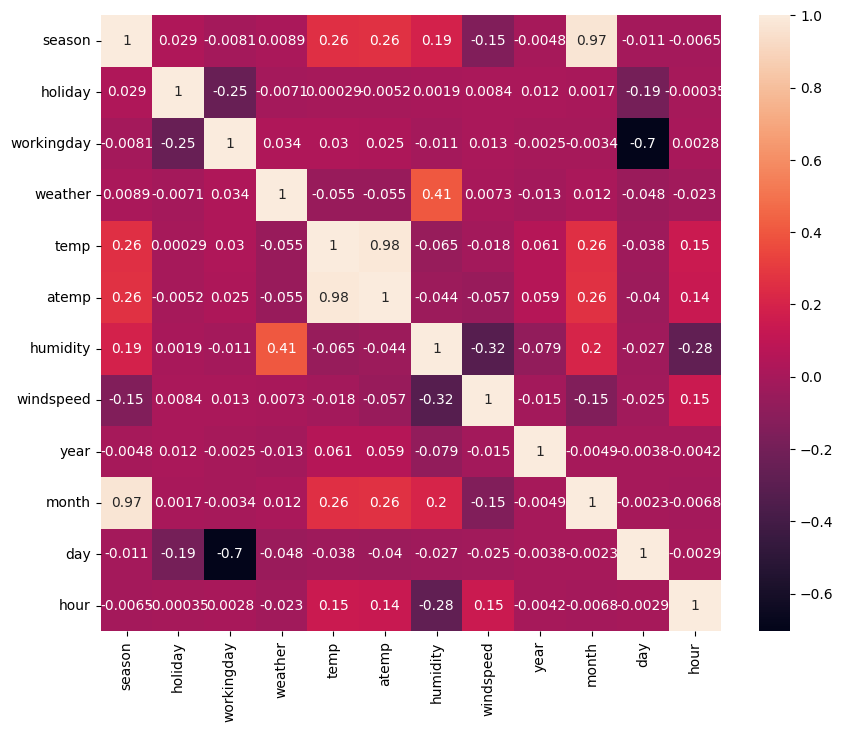

In [20]:
sns.heatmap(train.drop(['count', 'registered','casual'], axis=1).corr(), annot=True);

Make category types for these so models know they are not just numbers

- AutoGluon originally sees these as ints, but in reality they are int representations of a category.
- Setting the dtype to category will classify these as categories in AutoGluon.

In [21]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")

In [22]:
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [23]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  year        10886 non-null  int32   
 12  month       10886 non-null  int32   
 13  day         10886 non-null  int32   
 14  hour        10886 non-null  int32   
dtypes: category(2), float64(3), int32(4), int64(6)
memory usage: 957.3 KB


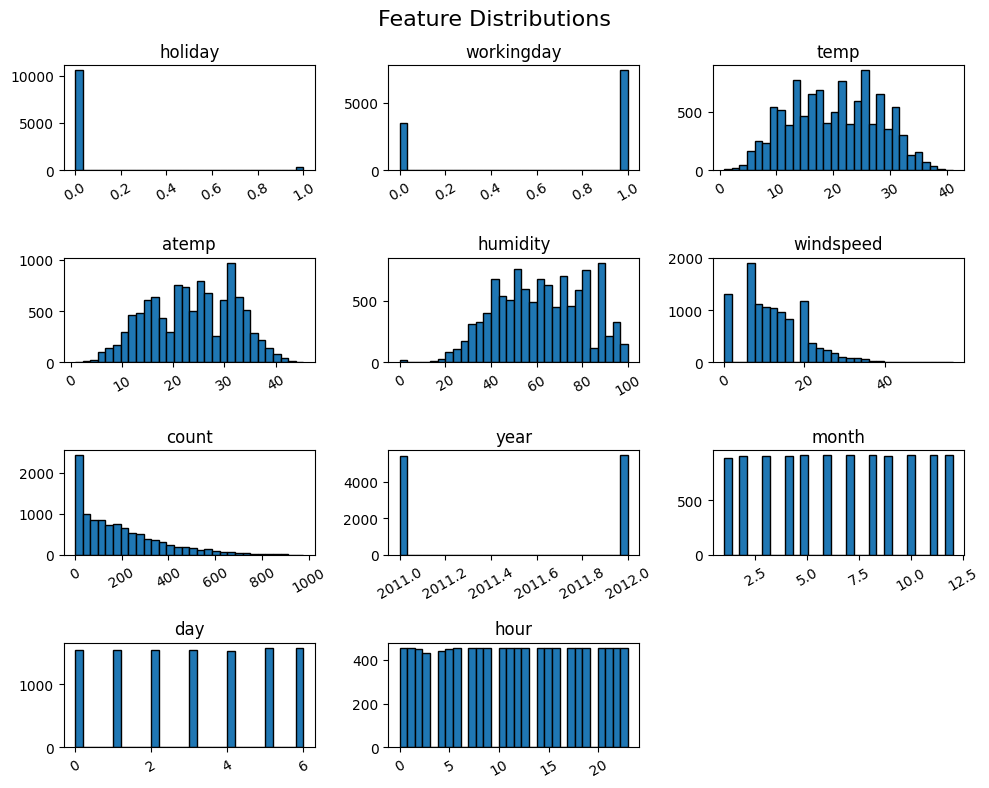

In [25]:
columns_to_plot = train.drop(columns=["casual", "registered"])
columns_to_plot.hist(figsize=(10, 8), bins=30, edgecolor="black", grid=False)
plt.suptitle("Feature Distributions", fontsize=16)

# Rotate x-axis tick labels
for ax in plt.gcf().axes:
    plt.sca(ax)
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(
    label="count",
    problem_type="regression",
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]},
    verbosity=1,
).fit(
    train,
    time_limit=600,
    presets="best_quality",
    num_gpus=1
)

In [26]:
predictor_new_features = TabularPredictor.load("AutogluonModels/ag-20250316_161054/")

In [27]:
predictor_new_features.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-34.784383,root_mean_squared_error,13.343726,372.494570,0.001917,0.160628,3,True,16
1,WeightedEnsemble_L2,-35.157984,root_mean_squared_error,10.286174,220.224452,0.002084,0.158475,2,True,9
2,ExtraTreesMSE_BAG_L2,-35.296944,root_mean_squared_error,11.828076,269.240852,0.576075,4.049918,2,True,14
3,CatBoost_BAG_L2,-35.298883,root_mean_squared_error,11.323862,343.556388,0.071861,78.365454,2,True,13
4,LightGBM_BAG_L2,-35.340126,root_mean_squared_error,11.453786,271.747980,0.201784,6.557046,2,True,11
5,LightGBMXT_BAG_L2,-35.753243,root_mean_squared_error,11.772928,273.148243,0.520927,7.957310,2,True,10
6,RandomForestMSE_BAG_L2,-35.909300,root_mean_squared_error,11.971161,275.404212,0.719160,10.213279,2,True,12
7,CatBoost_BAG_L1,-36.012381,root_mean_squared_error,0.772596,210.349176,0.772596,210.349176,1,True,6
8,LightGBMXT_BAG_L1,-37.553799,root_mean_squared_error,8.882175,6.293763,8.882175,6.293763,1,True,3
9,ExtraTreesMSE_BAG_L1,-39.963913,root_mean_squared_error,0.378903,1.448199,0.378903,1.448199,1,True,7


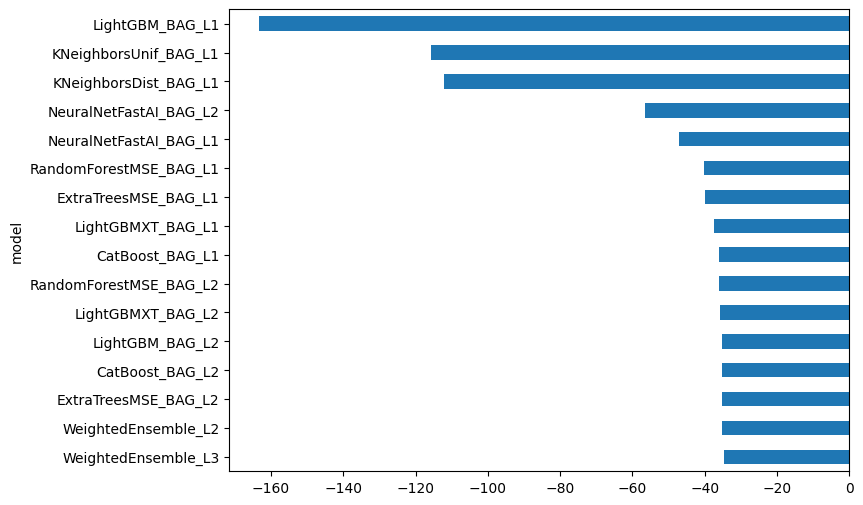

In [28]:
predictor_new_features.leaderboard().plot(figsize=(8, 6), kind="barh", x="model", y="score_val", legend=False);

In [29]:
# Create predictions from test dataset
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    13.167130
1     5.594612
2     3.472263
3     3.062869
4     2.797724
Name: count, dtype: float32

In [30]:
# How many negative values do we have?
predictions_new_features[predictions_new_features < 0].count()

14

In [31]:
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features < 0] = 0

In [32]:
# Same submitting predictions
submission_new_features = pd.read_csv("data/sampleSubmission.csv", parse_dates = ["datetime"])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

In [33]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                        description                        status                     publicScore  privateScore  
---------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
submission_new_hpo.csv       2025-03-16 18:46:47.077000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.47256      0.47256       
submission_new_features.csv  2025-03-16 16:27:53.403000  new features                       SubmissionStatus.COMPLETE  0.46987      0.46987       
submission.csv               2025-03-16 15:00:09.723000  first raw submission               SubmissionStatus.COMPLETE  1.75122      1.75122       


<font color="blue"> 

New score - **0.46987**

</font>

## Hyperparameter Optimization

- There are many options for hyperparameter optimization.
- Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
- The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

**Reference**: https://auto.gluon.ai/stable/tutorials/tabular/tabular-indepth.html#specifying-hyperparameters-and-tuning-them

In [ ]:
# Specifies non-default hyperparameter values for neural network models
nn_options = {
    "num_epochs": 10,  # number of training epochs (controls training time of NN models)
    "learning_rate": space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    "activation": space.Categorical("relu", "softrelu", "tanh"),  # activation function used in NN (categorical hyperparameter, default = first entry)
    "dropout_prob": space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

# Specifies non-default hyperparameter values for lightGBM gradient boosted trees
gbm_options = {
    "num_boost_round": 100,  # number of boosting rounds (controls training time of GBM models)
    "num_leaves": space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

# Hyperparameters of each model type
hyperparameters = {
    "GBM": gbm_options,
    "NN_TORCH": nn_options,
}

num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = "auto"  # to tune hyperparameters using random search routine with a local scheduler

# HPO is not performed unless hyperparameter_tune_kwargs is specified
hyperparameter_tune_kwargs = {
    "num_trials": num_trials,
    "searcher": search_strategy,
    "scheduler" : "local"
}

In [ ]:
predictor_new_hpo = TabularPredictor(
    label="count",
    problem_type="regression",
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]},
    verbosity=1,
).fit(
    train,
    time_limit=600,
    presets="best_quality",
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
    num_gpus=1
)

In [34]:
predictor_new_hpo = TabularPredictor.load("AutogluonModels/ag-20250316_183530/")

In [35]:
predictor_new_hpo.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-38.682782,root_mean_squared_error,2.488654,186.657064,0.000000,0.053878,3,True,15
1,LightGBM_BAG_L2\T3,-39.015234,root_mean_squared_error,1.393518,90.303129,0.252828,12.209880,2,True,10
2,LightGBM_BAG_L2\T1,-39.096029,root_mean_squared_error,1.328818,91.660666,0.188128,13.567417,2,True,8
3,LightGBM_BAG_L2\T2,-39.114742,root_mean_squared_error,1.258839,88.327920,0.118149,10.234671,2,True,9
4,LightGBM_BAG_L2\T5,-39.487582,root_mean_squared_error,1.334927,88.380422,0.194237,10.287174,2,True,12
5,WeightedEnsemble_L2,-39.627104,root_mean_squared_error,0.473249,20.780312,0.007985,0.069992,2,True,7
6,LightGBM_BAG_L1\T3,-40.329800,root_mean_squared_error,0.227846,10.422356,0.227846,10.422356,1,True,3
7,LightGBM_BAG_L1\T2,-40.386716,root_mean_squared_error,0.237418,10.287964,0.237418,10.287964,1,True,2
8,NeuralNetTorch_BAG_L2\b563ba89,-40.402295,root_mean_squared_error,1.458928,112.253244,0.318238,34.159995,2,True,13
9,LightGBM_BAG_L1\T1,-42.511802,root_mean_squared_error,0.245091,11.548284,0.245091,11.548284,1,True,1


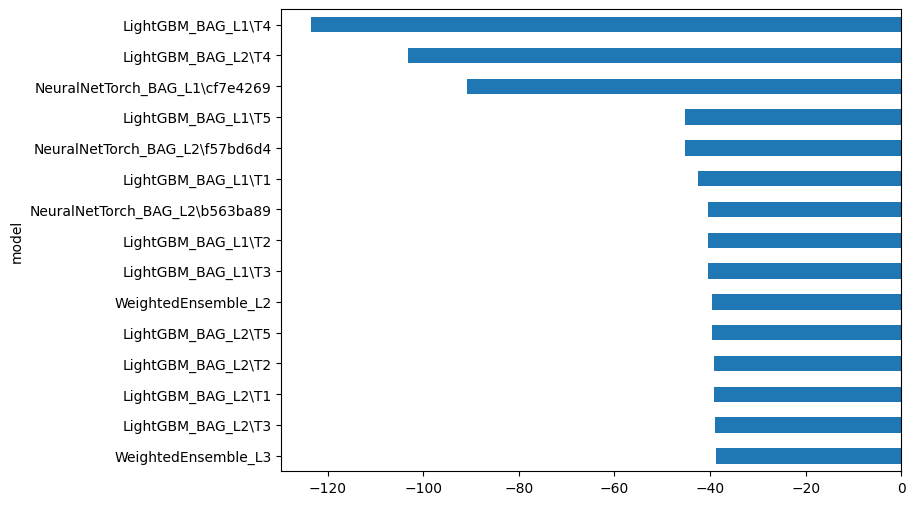

In [36]:
predictor_new_hpo.leaderboard().plot(figsize=(8, 6), kind="barh", x="model", y="score_val", legend=False);

In [37]:
# Create predictions from test dataset
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    12.336304
1     6.837336
2     6.563452
3     6.282746
4     6.277852
Name: count, dtype: float32

In [38]:
# How many negative values do we have?
predictions_new_hpo[predictions_new_hpo < 0].count()

0

In [39]:
# Same submitting predictions
submission_new_hpo = pd.read_csv("data/sampleSubmission.csv", parse_dates = ["datetime"])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

In [40]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                        description                        status                     publicScore  privateScore  
---------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
submission_new_hpo.csv       2025-03-16 18:46:47.077000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.47256      0.47256       
submission_new_features.csv  2025-03-16 16:27:53.403000  new features                       SubmissionStatus.COMPLETE  0.46987      0.46987       
submission.csv               2025-03-16 15:00:09.723000  first raw submission               SubmissionStatus.COMPLETE  1.75122      1.75122       


<font color="blue"> 

Last score - **0.47256**

</font>

## Write a Report

Refer to the markdown file for the full report

##### Creating plots and table for report

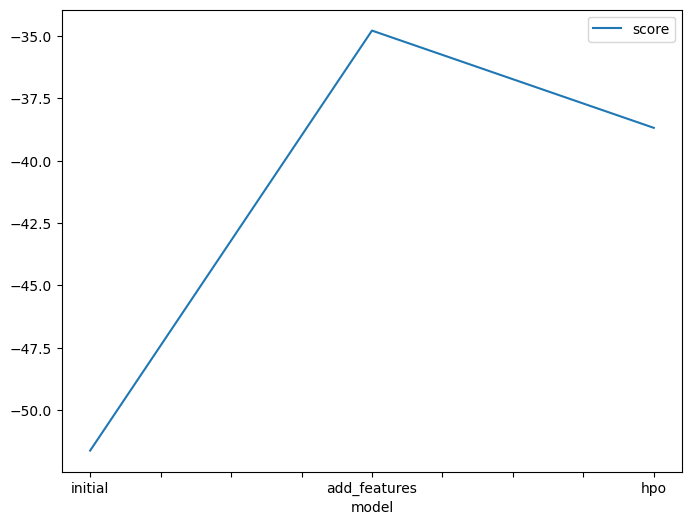

In [41]:
# Taking the top model score from each training run and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-51.617844, -34.784383, -38.682782]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig("assets/model_train_score.png")

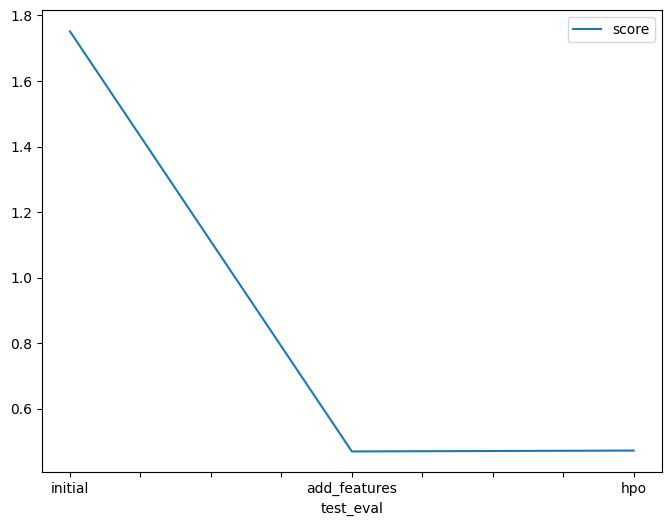

In [42]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.75122, 0.46987, 0.47256]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig("assets/model_test_score.png")

##### Hyperparameter table

In [43]:
# The 3 hyperparameters you tuned with the Kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["default", "default", "values for NN models"],
    "hpo2": ["default", "default", "values for LightGBM"],
    "hpo3": ["default", "default", "-"],
    "score": [1.75122, 0.46987, "0.47256"]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.75122
1,add_features,default,default,default,0.46987
2,hpo,values for NN models,values for LightGBM,-,0.47256
